In [21]:
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [22]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}

from cycler import cycler

plt.rcParams['axes.prop_cycle'] = cycler(color=[
    # Par 1: Tonos claros de azul
    "#004080",  # Azul medio 2 (más contraste)
    "#3A8DC6",  # Azul claro 2 (alejado del blanco)

    # Par 3: Tonos violeta/magenta
    "#D340A1",  # Magenta brillante 1
    "#A02C78",  # Violeta oscuro 2
])

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

In [23]:
def green(z, z_p, k): return 1j/(2*k)*jnp.exp(1j*k*np.abs(z - z_p))

In [24]:
z = np.linspace(-10,10,1_000)

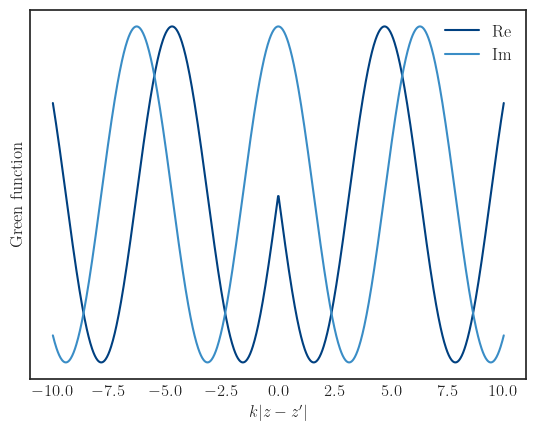

In [25]:
plt.plot(z, np.real(green(z, 0, 1)), label='Re')
plt.plot(z, np.imag(green(z, 0, 1)), label='Im')
plt.xlabel(r"$k|z-z'|$")
plt.ylabel('Green function')
plt.legend()
plt.yticks([])
plt.show()

In [76]:
# Parámetros físicos y geométricos
eps_0 = 8.8541878176e-12    # Permisividad eléctrica del vacío (F/m)
mu_0 = 4e-7*np.pi           # Permeabilidad magnética del vacío (H/m)
chi = 1e-10                  # Constante de acople magneto-eléctrica
eta_0 = np.sqrt(mu_0/eps_0) # Impedancia característica del vacío (Ohmios)

# Parámetros del problema
ka = 500*np.pi               # Producto del número de onda y la longitud característica (adimensional)
a = 10                      # Longitud característica (m)
k = ka/a                    # Número de onda (rad/m)
w = k/np.sqrt(eps_0*mu_0)   # Frecuencia angular (rad/s)

In [77]:
# Simulación
N_points = 1_000  # Número de puntos de discretización
z = jnp.linspace(0, a, N_points)
dz = z[1]-z[0]

# V = ZI
V = np.zeros(4*N_points, dtype=complex)  # Vector de excitación
Z = np.zeros((4*N_points, 4*N_points), dtype=complex)  # Matriz de impedancia inicializada en cero

In [78]:
# Campos Incidentes
E_0 = 1.0       # V/m
H_0 = E_0/eta_0 # A/m

V[::4], V[3::4] = E_0*jnp.exp(1j*k*z), H_0*jnp.exp(1j*k*z)

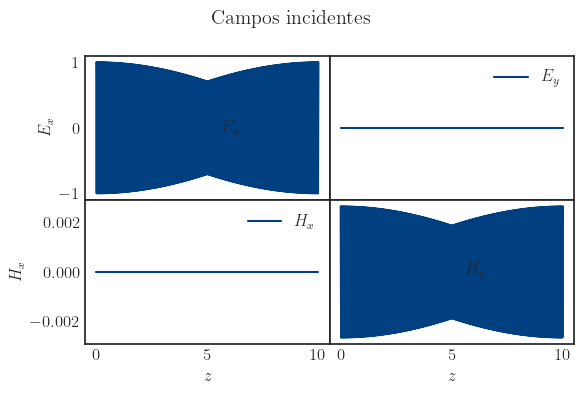

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey='row')

fig.suptitle('Campos incidentes')

# E_x
axs[0, 0].plot(z, jnp.real(V[::4]), label='$E_x$')
axs[0, 0].set_ylabel("$E_x$")
axs[0, 0].legend()

# E_y
axs[0, 1].plot(z, jnp.real(V[1::4]), label='$E_y$')
axs[0, 1].legend()

# H_x
axs[1, 0].plot(z, jnp.real(V[2::4]), label='$H_x$')
axs[1, 0].set_xlabel("$z$")
axs[1, 0].set_ylabel("$H_x$")
axs[1, 0].legend()

# H_y
axs[1, 1].plot(z, jnp.real(V[3::4]), label='$H_y$')
axs[1, 1].set_xlabel("$z$")
axs[1, 1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [80]:
# Matriz de impedancia
for j, zj in enumerate(z):
    # Términos de acoplamiento magneto-eléctrico en la matriz de impedancia
    Z[4*j+0, 4*j+2] += 1/(w*chi)
    Z[4*j+1, 4*j+3] += 1/(w*chi)
    Z[4*j+2, 4*j+0] -= 1/(w*chi)
    Z[4*j+3, 4*j+1] -= 1/(w*chi)

    # Cálculo de las funciones de Green desplazadas
    g_m = green(zj, z - dz/2, k)
    g_p = green(zj, z + dz/2, k)

    # Términos de la matriz de impedancia de a derivada t de los potenciales
    Z[4*j+0, 0::4] += -0.5j*w*mu_0*dz*(g_m+g_p)
    Z[4*j+1, 1::4] += -0.5j*w*mu_0*dz*(g_m+g_p)
    Z[4*j+2, 2::4] += -0.5j*w*eps_0*dz*(g_m+g_p)
    Z[4*j+3, 3::4] += -0.5j*w*eps_0*dz*(g_m+g_p)

    # Términos cruzados de la matriz de impedancia del rotacional de los potenciales
    Z[4*j+0, 3::4] += (g_m-g_p)
    Z[4*j+1, 2::4] +=-(g_m-g_p)
    Z[4*j+2, 1::4] +=-(g_m-g_p)
    Z[4*j+3, 0::4] += (g_m-g_p)

In [81]:
# Convertir a jax
V = jnp.array(V)
Z = jnp.array(Z)

In [82]:
I = np.array(jnp.linalg.solve(Z, V))

In [83]:
# Verificar campo incidente
V_s = Z @ I

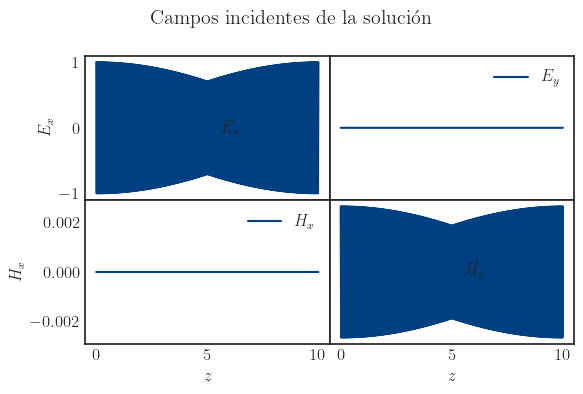

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey='row')

fig.suptitle('Campos incidentes de la solución')

# E_x
axs[0, 0].plot(z, jnp.real(V_s[::4]), label='$E_x$')
axs[0, 0].set_ylabel("$E_x$")
axs[0, 0].legend()

# E_y
axs[0, 1].plot(z, jnp.real(V_s[1::4]), label='$E_y$')
axs[0, 1].legend()

# H_x
axs[1, 0].plot(z, jnp.real(V_s[2::4]), label='$H_x$')
axs[1, 0].set_xlabel("$z$")
axs[1, 0].set_ylabel("$H_x$")
axs[1, 0].legend()

# H_y
axs[1, 1].plot(z, jnp.real(V_s[3::4]), label='$H_y$')
axs[1, 1].set_xlabel("$z$")
axs[1, 1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [85]:
# Campos dispersados
S = np.zeros(4*N_points, dtype=complex)

for j, zj in enumerate(z):
    # Cálculo de las funciones de Green desplazadas
    g_m = green(zj, z - dz/2, k)
    g_p = green(zj, z + dz/2, k)

    # Términos de la matriz de impedancia de a derivada t de los potenciales
    S[4*j+0] += 0.5j*w*mu_0*dz*jnp.sum((g_m+g_p)*I[0::4])
    S[4*j+1] += 0.5j*w*mu_0*dz*jnp.sum((g_m+g_p)*I[1::4])
    S[4*j+2] += 0.5j*w*eps_0*dz*jnp.sum((g_m+g_p)*I[2::4])
    S[4*j+3] += 0.5j*w*eps_0*dz*jnp.sum((g_m+g_p)*I[3::4])

    # Términos cruzados del rotacional de los potenciales
    S[4*j+0] +=-jnp.sum((g_m-g_p)*I[3::4])
    S[4*j+1] += jnp.sum((g_m-g_p)*I[2::4])
    S[4*j+2] += jnp.sum((g_m-g_p)*I[1::4])
    S[4*j+3] +=-jnp.sum((g_m-g_p)*I[0::4])

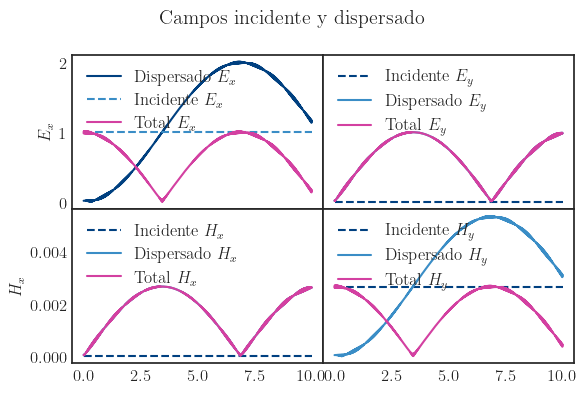

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey='row')

fig.suptitle('Campos incidente y dispersado')

# E_x
axs[0, 0].plot(z, jnp.abs(S[0::4]), label='Dispersado $E_x$')
axs[0, 0].plot(z, jnp.abs(V[0::4]), label='Incidente $E_x$', linestyle='--')
axs[0, 0].plot(z, jnp.abs(V[0::4]+S[0::4]), label='Total $E_x$')
axs[0, 0].set_ylabel("$E_x$")
axs[0, 0].legend()

# E_y
axs[0, 1].plot(z, jnp.abs(V[1::4]), label='Incidente $E_y$', linestyle='--')
axs[0, 1].plot(z, jnp.abs(S[1::4]), label='Dispersado $E_y$')
axs[0, 1].plot(z, jnp.abs(V[1::4]+S[1::4]), label='Total $E_y$')
axs[0, 1].legend()

# H_x
axs[1, 0].plot(z, jnp.abs(V[2::4]), label='Incidente $H_x$', linestyle='--')
axs[1, 0].plot(z, jnp.abs(S[2::4]), label='Dispersado $H_x$')
axs[1, 0].plot(z, jnp.abs(V[2::4]+S[2::4]), label='Total $H_x$')
axs[1, 0].set_ylabel("$H_x$")
axs[1, 0].legend()

# H_y
axs[1, 1].plot(z, jnp.abs(V[3::4]), label='Incidente $H_y$', linestyle='--')
axs[1, 1].plot(z, jnp.abs(S[3::4]), label='Dispersado $H_y$')
axs[1, 1].plot(z, jnp.abs(V[3::4]+S[3::4]), label='Total $H_y$')
axs[1, 1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

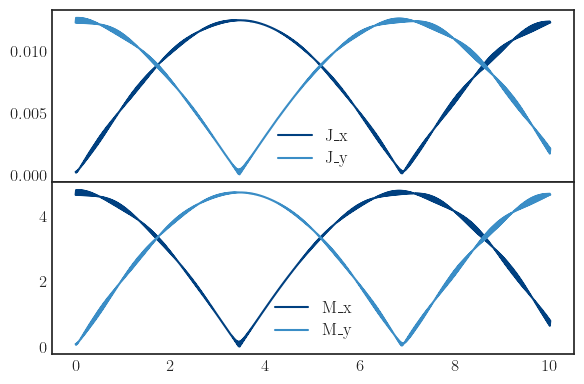

In [87]:
# Corrientes equivalentes

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey='row')

# J_x, J_y
axs[0].plot(z, jnp.abs(I[0::4]), label='J_x')
axs[0].plot(z, jnp.abs(I[1::4]), label='J_y')
axs[0].legend()

# M_x, M_y
axs[1].plot(z, jnp.abs(I[2::4]), label='M_x')
axs[1].plot(z, jnp.abs(I[3::4]), label='M_y')
axs[1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [88]:
# Campos dispersados fuera del scatterer
z_p = np.linspace(a, 2*a, N_points)
S_p = np.zeros(4*N_points, dtype=complex)

for j, zj in enumerate(z_p):
    # Cálculo de las funciones de Green desplazadas
    g_m = green(zj, z - dz/2, k)
    g_p = green(zj, z + dz/2, k)

    # Términos de la matriz de impedancia de a derivada t de los potenciales
    S[4*j+0] += 0.5j*w*mu_0*dz*jnp.sum((g_m+g_p)*I[0::4])
    S[4*j+1] += 0.5j*w*mu_0*dz*jnp.sum((g_m+g_p)*I[1::4])
    S[4*j+2] += 0.5j*w*eps_0*dz*jnp.sum((g_m+g_p)*I[2::4])
    S[4*j+3] += 0.5j*w*eps_0*dz*jnp.sum((g_m+g_p)*I[3::4])

    # Términos cruzados del rotacional de los potenciales
    S[4*j+0] +=-jnp.sum((g_m-g_p)*I[3::4])
    S[4*j+1] += jnp.sum((g_m-g_p)*I[2::4])
    S[4*j+2] += jnp.sum((g_m-g_p)*I[1::4])
    S[4*j+3] +=-jnp.sum((g_m-g_p)*I[0::4])

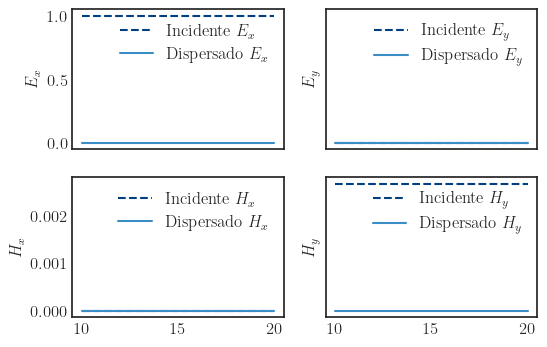

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey='row')

# E_x
axs[0, 0].plot(z_p, jnp.abs(E_0*jnp.exp(1j*k*z_p)), label='Incidente $E_x$', linestyle='--')
axs[0, 0].plot(z_p, jnp.abs(S_p[0::4]), label='Dispersado $E_x$')
axs[0, 0].set_ylabel("$E_x$")
axs[0, 0].legend()

# E_y
axs[0, 1].plot(z_p, jnp.zeros(len(z_p)), label='Incidente $E_y$', linestyle='--')
axs[0, 1].plot(z_p, jnp.abs(S_p[1::4]), label='Dispersado $E_y$')
axs[0, 1].set_ylabel("$E_y$")
axs[0, 1].legend()

# H_x
axs[1, 0].plot(z_p, jnp.zeros(len(z_p)), label='Incidente $H_x$', linestyle='--')
axs[1, 0].plot(z_p, jnp.abs(S_p[2::4]), label='Dispersado $H_x$')
axs[1, 0].set_ylabel("$H_x$")
axs[1, 0].legend()

# H_y
axs[1, 1].plot(z_p, jnp.abs(H_0*jnp.exp(1j*k*z_p)), label='Incidente $H_y$', linestyle='--')
axs[1, 1].plot(z_p, jnp.abs(S_p[3::4]), label='Dispersado $H_y$')
axs[1, 1].set_ylabel("$H_y$")
axs[1, 1].legend()


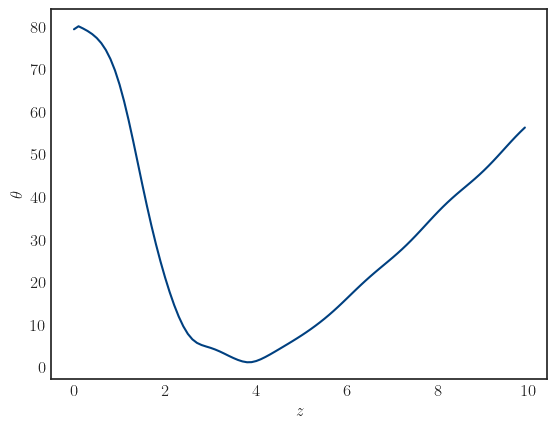

In [94]:
# Plano de polarización
plt.plot(z[::10], jnp.degrees(jnp.arctan(jnp.abs(S[1::4])/jnp.abs(V[0::4]+S[0::4])))[::10])
plt.xlabel(r"$z$")
plt.ylabel(r"$\theta$")
plt.show()